In [1]:
import numpy as np
from helper import Particle, Point, distance
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# customize plot
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 14
rcParams['font.family'] = 'StixGeneral'

In [2]:
n = 50
weight = 1/n
domain = 1

source_coord = np.random.random((n, 3)).tolist()
target_coord = (-np.random.random((n, 3))).tolist()
sources = [Particle(coord, w = weight) for coord in source_coord]
targets = [Particle(coord, w = weight) for coord in target_coord]

In [3]:
class Cell:
    def __init__(self, x = None, y = None, z = None) -> None:
        self.x = x
        self.y = y
        self.z = z
        self.multipole = np.zeros(10) # totally 10 terms

In [4]:
parent = Cell(domain/2, domain/2, domain/2)
# create an array of 8 child cells
octant = np.arange(8)
x = (octant % 2) * parent.x + parent.x/2
y = ((octant//2) % 2) * parent.y + parent.y/2
z = ((octant//4) % 2) * parent.z + parent.z/2
children = [Cell(x[i], y[i], z[i]) for i in range(8)]

In [5]:
def get_child_multipole(sources, parent, children):
    for source in sources:
        # split the sources into child cells, and calculate the child's n.o.
        i = (source.x > parent.x) + ((source.y > parent.y) << 1) + ((source.z > parent.z) << 2) 
        dx, dy, dz = children[i].x-source.x, children[i].y-source.y, children[i].z-source.z
        
        children[i].multipole += source.w * np.array((1, dx, dy, dz, dx**2/2, dy**2/2, dz**2/2, dx*dy/2, dy*dz/2, dz*dx/2))

In [6]:
get_child_multipole(sources, parent, children)

In [7]:
def get_parent_multipole(parent, children):
    for child in children:
        dx, dy, dz = parent.x - child.x, parent.y - child.y, parent.z - child.z
        parent.multipole += child.multipole
        parent.multipole[1:4] += child.multipole[0] * np.array((dx, dy, dz))
        parent.multipole[4:7] += child.multipole[1:4] * np.array((dx, dy, dz)) + 0.5 * child.multipole[0] * np.array((dx**2, dy**2, dz**2))
        parent.multipole[7:] += 0.5 * child.multipole[1:4] * np.array((dx, dy, dz)) + \
                                0.5 * child.multipole[0] * np.array((dx*dy, dy*dz, dz*dx)) + \
                                0.5 * np.array((child.multipole[1], child.multipole[2], child.multipole[3]))\
                                    * child.multipole[1] * np.array((dx, dy, dz))

In [8]:
get_parent_multipole(parent, children)

In [9]:
# given targets list, multipole and expansion center, return the array of the targets' potentials
def eval_potential(targets, multipole, center):
    x = np.array([target.x for target in targets])
    y = np.array([target.y for target in targets])
    z = np.array([target.z for target in targets])
    targets_coord = [x, y, z]
    r = distance(targets_coord, center)

    dx, dy, dz = x-center.x, y-center.y, z-center.z
    r3 = r**3
    r5 = r**5
    
    multipole_coef = [1/r, -dx/r3, -dy/r3, -dz/r3, 3*dx**2/r5 - 1/r3, 3*dy**2/r5 - 1/r3, \
                        3*dz**2/r5 - 1/r3, 3*dx*dy/r5, 3*dy*dz/r5, 3*dz*dx/r5]
    u = np.dot(multipole, multipole_coef)
    return u

In [10]:
u_multi = eval_potential(targets, parent.multipole, parent)

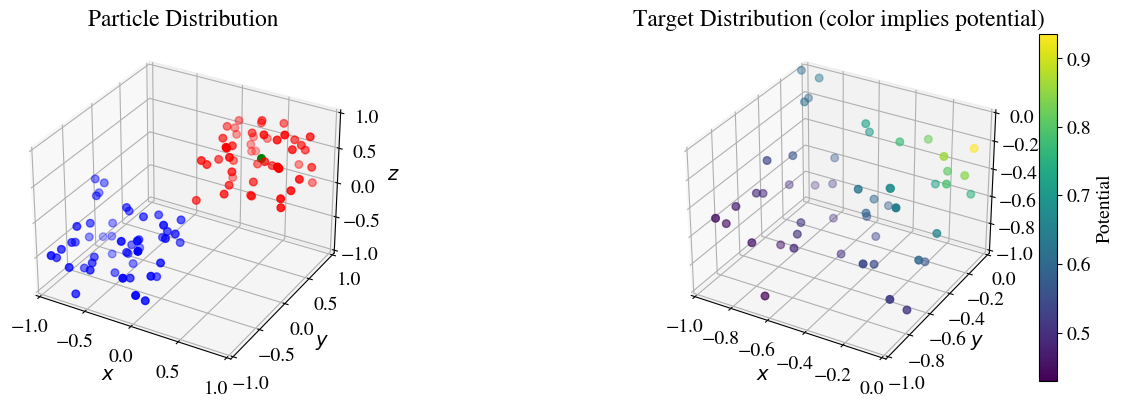

In [13]:
# plot spatial particle distribution
fig = plt.figure(figsize=(18,4.5))
# left plot
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter([target.x for target in targets], 
           [target.y for target in targets], 
           [target.z for target in targets], s=30, c='b')
ax.scatter([source.x for source in sources], 
           [source.y for source in sources], 
           [source.z for source in sources], s=30, c='r')

ax.scatter(parent.x, parent.y, parent.z, s=30, c='g')

ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_title('Particle Distribution')
# right plot
ax = fig.add_subplot(1,2,2, projection='3d')
scale = 100   # scale for dot size in scatter plot
u_min, u_max = np.min(u_multi), np.max(u_multi)
color_norm = plt.Normalize(u_min, u_max)
cmap = plt.cm.get_cmap('viridis')
scatter = ax.scatter([target.x for target in targets], 
           [target.y for target in targets], 
           [target.z for target in targets],
           s=30, c=u_multi, cmap = cmap, norm = color_norm)
ax.set_xlim3d(-1,0)
ax.set_ylim3d(-1,0)
ax.set_zlim3d(-1,0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Target Distribution (color implies potential)')

# Add colorbar legend
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Potential')
cbar.ax.set_position([3, 0.1, 0.03, 0.8])

plt.subplots_adjust(right=0.8)

plt.show()